<a href="https://colab.research.google.com/github/AliyaMingaleeva/-Python/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D1%86%D0%B5%D0%BD_%D0%BD%D0%B0_%D0%BD%D0%B5%D0%B4%D0%B2%D0%B8%D0%B6%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Прогноз цен на недвижимость***

Описания файлов
train.csv — обучающий набор
test.csv - тестовый набор
sampleSubmission.csv — образец файла отправки в правильном формате.
Поля данных
Id - объемный номер квартиры
DistrictId - распространенный номер района
Комнаты - количество комнат
Площадь - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Этаж - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Экология_1, Экология_2, Экология_3 - экологические оценки местности
Social_1, Social_2, Social_3 - социальные области местности
Здравоохранение_1, Здравоохранение_2 - границы местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Цена - цена квартиры

**Подключение библиотек и скриптов**

In [ ]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.manifold import TSNE

**Добавляем функцию для расчета метрик на данных и построении графиков**

In [ ]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [ ]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

**1. Загрузка данных**

**Описание задачи**

Цель - предсказать цены на квартиры

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

Считываем данные. По строкам - наблюдения, по столбцам - признаки.


Train данные

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [ ]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

Test данные

In [ ]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [ ]:
print('Строк в train:', train_df.shape)
print('Строк в test', test_df.shape)

Строк в train: (10000, 20)
Строк в test (5000, 19)


Зависимость признаков

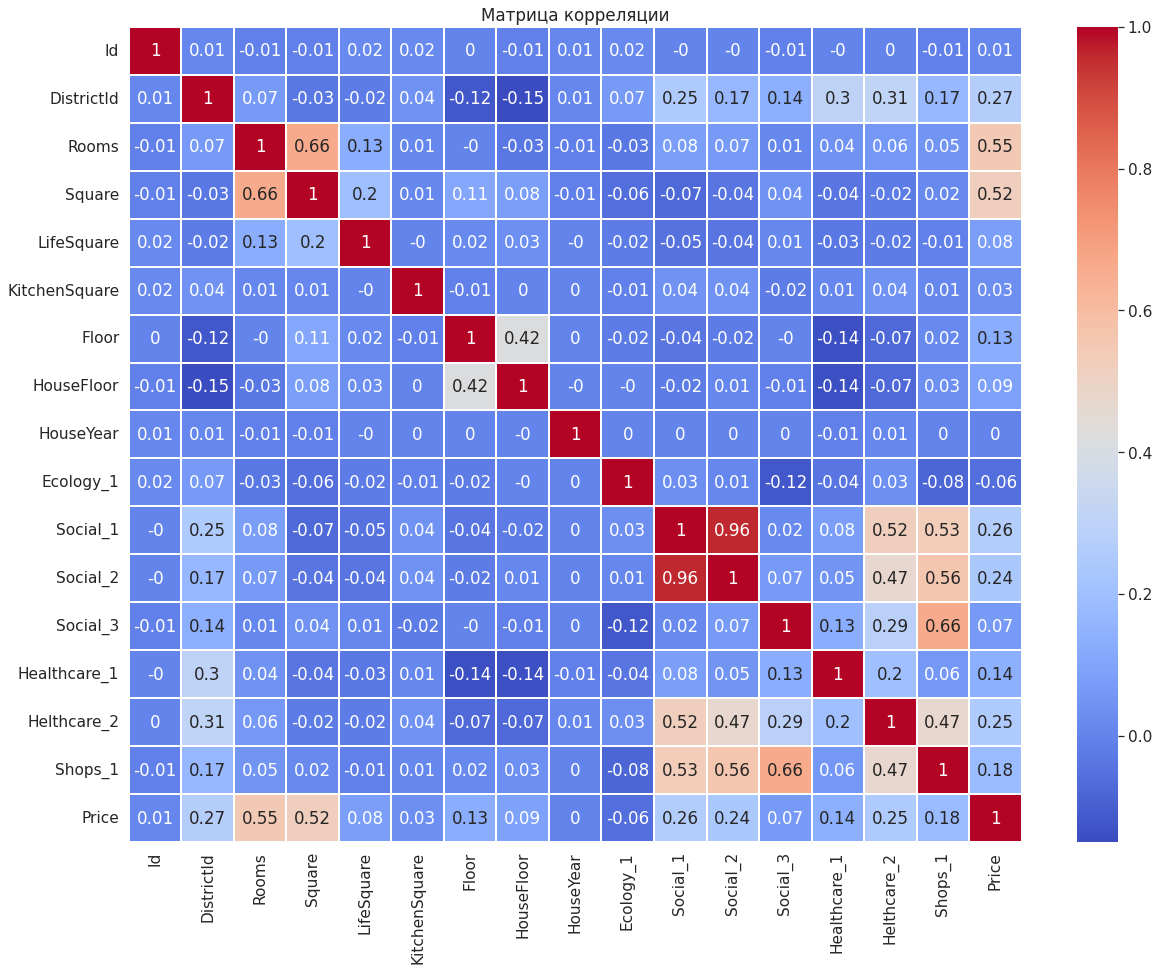

In [ ]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=1, cmap='coolwarm')

plt.title('Матрица корреляции')
plt.show()

На основании матрицы корреляции можно увидеть зависимость стоимости квартиры от количества комнат и общей площади.

Высокая корреляция (0.96) между Social_1 и Social_2_эти два показателя можно объединить.

**2. Приведение типовых данных**

In [ ]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [ ]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

Категориальные данные ID и Districtld изменим на строковые параметры, чтобы исключить их из обучения:

In [ ]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [ ]:
train_df.dtypes.value_counts()

float64    8
int64      7
object     5
dtype: int64

**3. Обзор данных и обработка данных**

**Целевая переменная**

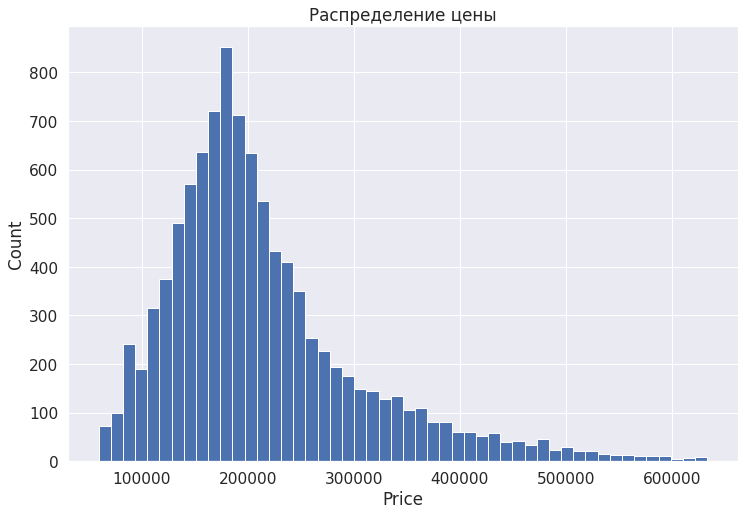

In [ ]:
plt.figure(figsize= (12,8))

train_df['Price'].hist (bins=50)
plt.ylabel ('Count')
plt.xlabel ('Price')

plt.title('Распределение цены')
plt.show()


In [ ]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = round(train_df['Price'].median(),2)

target_mean, target_median

(214138.86, 192269.64)

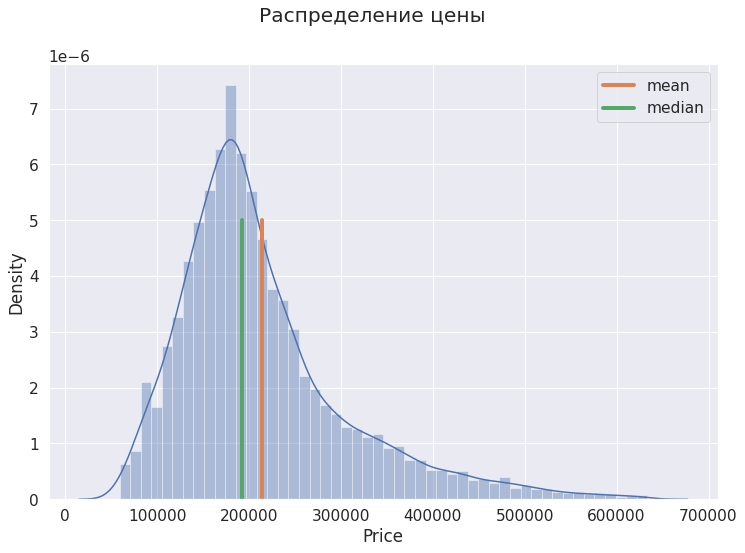

In [ ]:
plt.figure(figsize = (12, 8))

sns.distplot(train_df['Price'], bins = 50)

y = np.linspace(0, 0.000005, 2) #(2 точки для рисования прямой линии на графике)
plt.plot([target_mean] * 2, y, label = 'mean', linewidth = 4)
plt.plot([target_median] * 2, y, label = 'median', linewidth = 4)

plt.suptitle('Распределение цены')
plt.legend()
plt.show()

**Количественные переменные**

Первичное понимание, что представляют собой данные

In [ ]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [ ]:
print('Количество нулевых значений =', str(train_df.isnull().sum().sum()))

Количество нулевых значений = 6911


In [ ]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

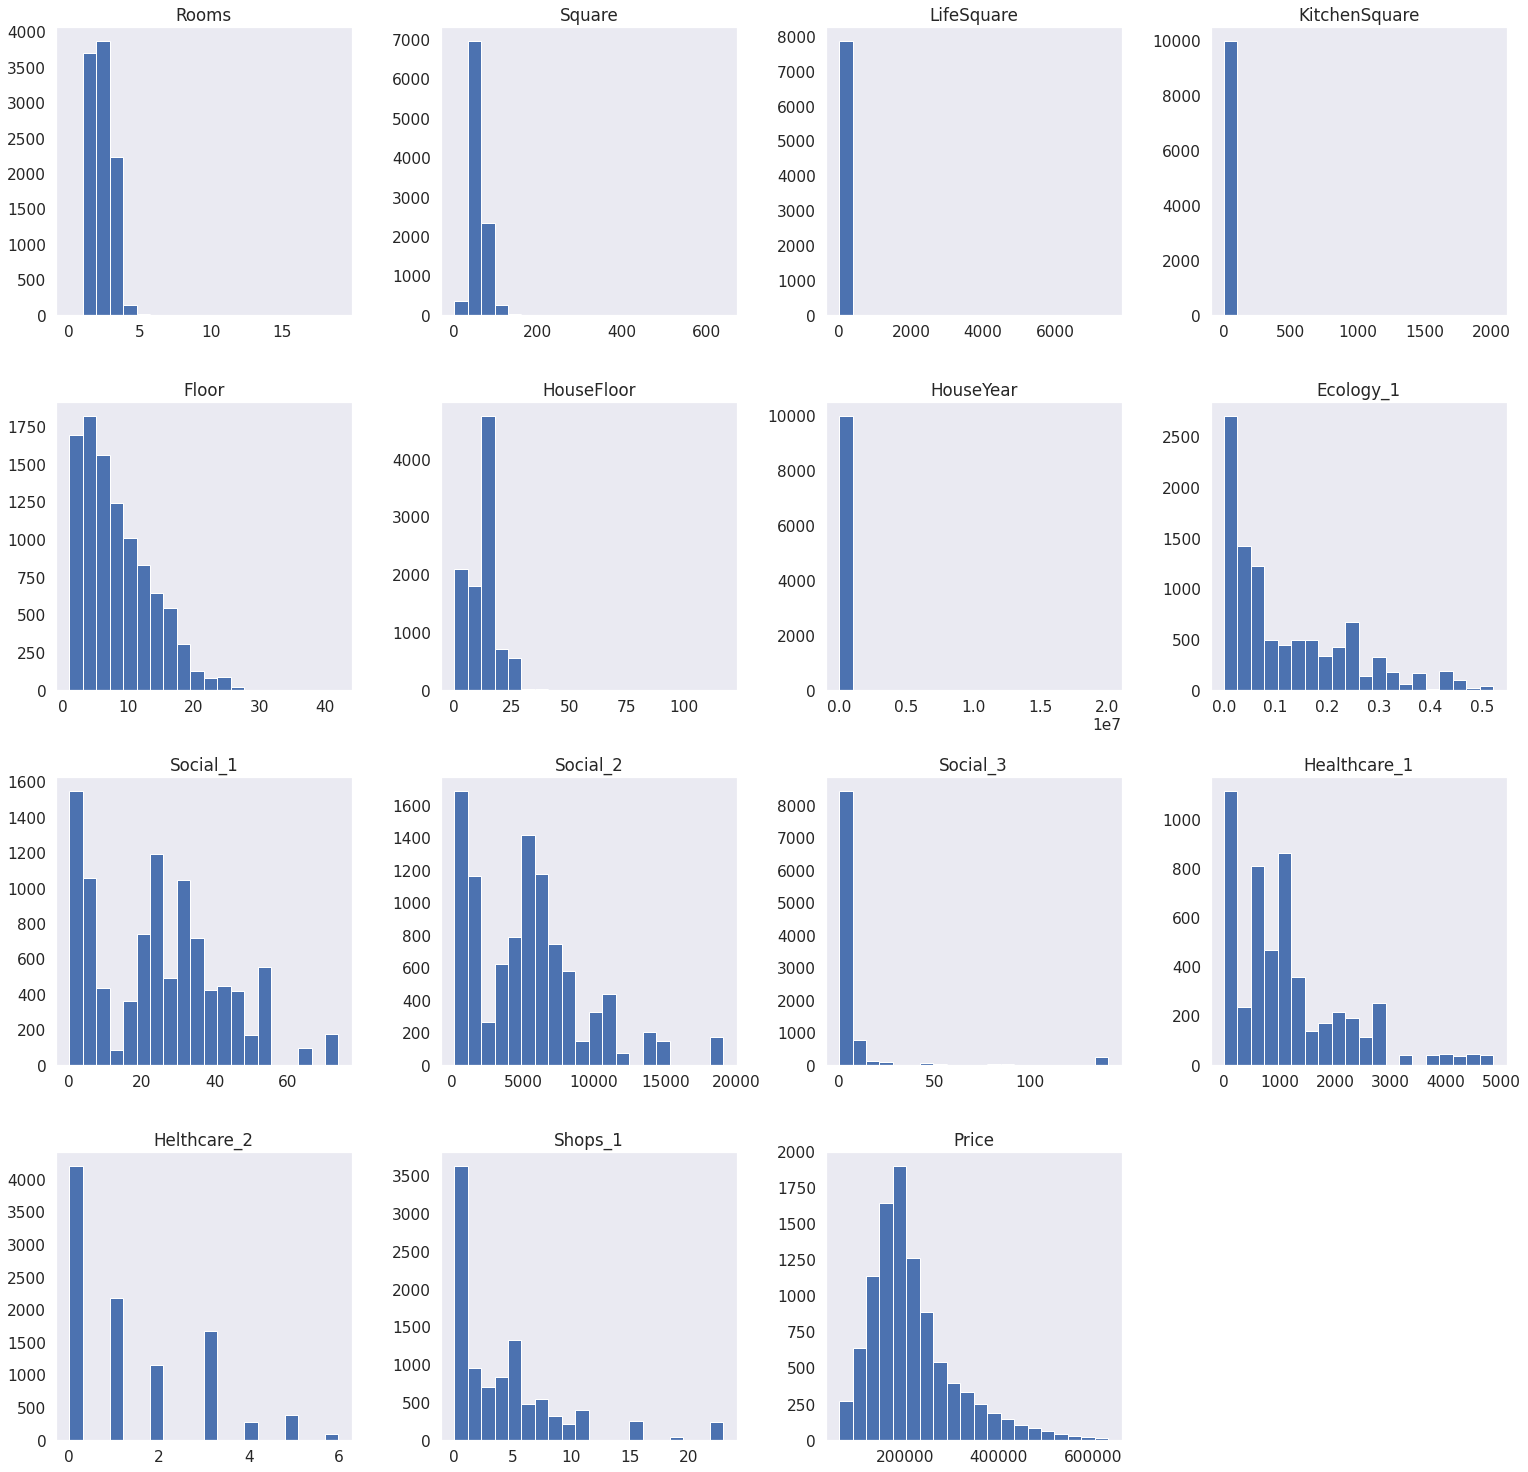

In [ ]:
train_df.select_dtypes(include=['float64', 'int64', 'float16']).hist(figsize=(26,26), bins=20, grid=False);

**Номинативные переменные**

In [ ]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [ ]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [ ]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [ ]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [ ]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**4. Обработка пропусков и выбросов**

**ROOMS**

In [ ]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.871089
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.720850
3,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.007630
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.102962


In [ ]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Добавляем новый бинарный признак для помечания выбросов по комнатам.
Заменим нулевые значения на медиану, а там где 5 и более комнат оставим 5-комнатные квартиры.

In [ ]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [ ]:
target_mean = round(train_df['Rooms'].mean(), 2)
target_median = round(train_df['Rooms'].median(),2)

target_mean, target_median

(1.89, 2.0)

In [ ]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'] >= 5, 'Rooms'] = 5

In [ ]:
train_df['Rooms'].value_counts()

2.0    3888
1.0    3705
3.0    2235
4.0     150
5.0      22
Name: Rooms, dtype: int64

**Square, LifeSquare, KitchenSquare**

In [ ]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.889600,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.001200
std,0.813436,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.034622
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000
max,5.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000


В столбцах Square, LifeSquare, KitchenSquare -  есть как странные большие площади, так и нулевые и очень маленькие показатели. В LifeSquare - заполнены только 7887 из 10000 значений, и где общая площадь меньше жилой.

Посмотрим через квантили

In [ ]:
train_df['Square'].quantile(.99), train_df['Square'].quantile(.01) 

(117.85611482113002, 29.719794884038905)

In [ ]:
target_mean = round(train_df['Square'].mean(), 2)
target_median = round(train_df['Square'].median(),2)

target_mean, target_median

(56.32, 52.51)

In [ ]:
train_df['LifeSquare'].quantile(.975), train_df['LifeSquare'].quantile(.025) 

(80.74810407514713, 5.914129735023812)

In [ ]:
target_mean = round(train_df['LifeSquare'].mean(), 2)
target_median = round(train_df['LifeSquare'].median(),2)

target_mean, target_median

(37.2, 32.78)

In [ ]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [ ]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025) 

(13.0, 0.0)

In [ ]:
target_mean = round(train_df['KitchenSquare'].mean(), 2)
target_median = round(train_df['KitchenSquare'].median(),2)

target_mean, target_median

(6.27, 6.0)

Предположим, что нулевые значения по кухне указаны в квартирах - студиях, чтобы не увеличивать площадь и исключить нулевые значения - заменим их на 1.

большие площади = выбросы - заменим на значение медианы

In [ ]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 1, 'KitchenSquare'] = 1

In [ ]:
train_df['KitchenSquare'].value_counts()

1.0     3157
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
3.0       22
2.0        4
Name: KitchenSquare, dtype: int64

In [ ]:
condition = (train_df['Square'].isna()) \
             | (train_df['Square'] > train_df['Square'].quantile(.99))
        
train_df.loc[condition, 'Square'] = train_df['Square'].median()

condition = (train_df['Square'].isna()) \
             | (train_df['Square'] < train_df['Square'].quantile(.01))
        
train_df.loc[condition, 'Square'] = train_df['Square'].median()


проверяем, где  Общая площадь меньше суммарной площади кухни, жилой и нежилой (условно взять 3 кв.м)

In [ ]:
((train_df['KitchenSquare']+train_df['LifeSquare']+3) > train_df['Square']).sum()

1191

In [ ]:
condition = (train_df['LifeSquare'].isna()) \
             | (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.01))
        
train_df.loc[condition, 'LifeSquare'] = train_df['LifeSquare'].median()


In [ ]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square'] - train_df['KitchenSquare'] - 3),'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - 3

In [ ]:
((train_df['KitchenSquare']+train_df['LifeSquare']+3) > train_df['Square']).sum()

0

In [ ]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.889600,55.605995,34.516477,5.60640,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.001200
std,0.813436,16.747121,13.335588,3.57306,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.034622
min,1.000000,29.719934,2.861966,1.00000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,1.000000,42.029122,25.868032,1.00000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000
50%,2.000000,52.513175,32.781260,6.00000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000
75%,2.000000,65.441619,39.513310,8.00000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000
max,5.000000,117.855969,112.494390,13.00000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000


**HouseFloor, Floor**

В значениях этажей - есть значения, кторые не вписываются в этажность дома.

Добавляем новый признак, где этажность равна 0, либо этаж выше этажности.
Нулевые этажности заменяем на медиану
Если этаж выше этажности = меняем местами

In [ ]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [ ]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [ ]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [ ]:
train_df.loc[(train_df['HouseFloor'] < train_df['Floor']), 'HouseFloor'] = train_df.loc[(train_df['HouseFloor'] < train_df['Floor']), 'Floor']

In [ ]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [ ]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

год подстройки 20052011 - это 2005 2011.
Заменим данный показатель на 2011
Год 4968 = 1968

In [ ]:
train_df.loc[train_df['HouseYear']  == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear']  == 20052011, 'HouseYear'] = 2011

In [ ]:
train_df['HouseYear'].sort_values(ascending=False)

8664    2020
6073    2020
7302    2020
9091    2020
9400    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int64

In [ ]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

48% Healthcear_1 - не заполнены (4798 из 10000), и так как выше мы смотрели по матрице корреляций - не было зависимости по данному показателю, то можно не учитывать в модели

In [ ]:
train_df['Healthcare_1'].head()

0       NaN
1    1183.0
2     240.0
3       NaN
4       NaN
Name: Healthcare_1, dtype: float64

In [ ]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [ ]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
dtype: int64

**Класс обработки данных**

In [ ]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.life_square_quantile = None
        self.square_quantile = None
        self.square_quantile2 = None

    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.life_square_quantile = X['LifeSquare'].quantile(.01)
        self.square_quantile = X['Square'].quantile(.99)
        self.square_quantile2 = X['Square'].quantile(.01)

    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = self.medians['Rooms']
        X.loc[X['Rooms'] >= 5, 'Rooms'] = 5

         # Square, KitchenSquare, LifeSquare
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 1, 'KitchenSquare'] = 1
        
        condition = (X['LifeSquare'].isna()) | (X['LifeSquare'] < self.life_square_quantile)
        X.loc[condition, 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

        condition = (X['Square'].isna()) | (X['Square'] > self.square_quantile)
        X.loc[condition, 'Square'] = self.medians['Square']
        condition = (X['Square'].isna()) | (X['Square'] < self.square_quantile2)
        X.loc[condition, 'Square'] = self.medians['Square']

        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] < X['Floor'], 'HouseFloor'] = X.loc[X['HouseFloor'] < X['Floor'], 'Floor']                                           
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        
        def HouseYear_cat(X):

            X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
            X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2011

            return X

        X = HouseYear_cat(X)

        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
               
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

**Новые признаки**

Переведем категориальные признаки в бинарные (экология_1, экология_2, магазины_2)

In [ ]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

Добавим на основе районов - признак частоты

In [ ]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [ ]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,11,3097,0,0,0,1,305018.871089,0,0,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1,0,1,177734.553407,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,3,1,1,282078.720850,0,0,652
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,...,1,264,0,0,1,1,168106.007630,0,0,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,0,6,1,343995.102962,0,0,89


In [ ]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [ ]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

Закодируем целевой признак через район и количество комнат

In [ ]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239


In [ ]:
med_price_by_district.shape

(671, 3)

In [ ]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,0,0,0,1,305018.871089,0,0,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1,0,1,177734.553407,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,3,1,1,282078.720850,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,...,0,0,1,1,168106.007630,0,0,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,0,6,1,343995.102962,0,0,89,0,201584.441255


Закодируем целевой признак через этаж и год MedPriceByFloorYear

In [ ]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 2, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 2) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X

def floor_to_cat_pandas(X):
    bins = [X['Floor'].min(), 2, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1932, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1932) & (X['HouseYear'] <= 1961), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1961) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X

def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1932, 1961, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [ ]:
bins = [train_df['Floor'].min(), 2, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1.0
1       2.0
2       0.0
3       3.0
4       4.0
       ... 
9995    1.0
9996    3.0
9997    1.0
9998    1.0
9999    2.0
Name: Floor, Length: 10000, dtype: float64

In [ ]:
bins = [train_df['Floor'].min(), 2, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (2, 5]
1         (5, 9]
2         (1, 2]
3        (9, 15]
4       (15, 42]
          ...   
9995      (2, 5]
9996     (9, 15]
9997      (2, 5]
9998      (2, 5]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(1, 2] < (2, 5] < (5, 9] < (9, 15] < (15, 42]]

In [ ]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,0,1,305018.871089,0,0,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,1,177734.553407,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,1,282078.720850,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,...,1,1,168106.007630,0,0,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,0,0,89,0,201584.441255,3,5


Группируем по году и этажу

In [ ]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,309988.239477
1,1,2,350361.674161
2,1,3,325326.767028
3,2,1,230977.733850
4,2,2,248375.618509


In [ ]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,851,1,213530.788443,6,2,159497.156410
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,78,0,146032.829834,3,3,186265.707329
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,652,1,244005.272380,4,1,201723.046732
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,652,1,146735.671740,3,4,184785.969760
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,89,0,201584.441255,3,5,181217.547184


**Класс обработки данных_новые признаки**

In [ ]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.district_size = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.floor_max = None
        self.floor_min = None
        self.house_year_max = None
        self.house_year_min = None
        
         
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        
         ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        


       
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        
        # More categorical features
        X = self.floor_to_cat(X)  
        X = self.year_to_cat(X)   

         
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X

    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1950, 1980, 2000, 2015, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

**Отбор признаков**

In [ ]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [ ]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear']

target_name = 'Price'

**5. Разбиение на Train и Test**

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

In [ ]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 28), (3300, 28), (5000, 28))

In [ ]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

**6. Построение модели**

Линейная регрессия

Train R2:	0.718
Test R2:	0.523


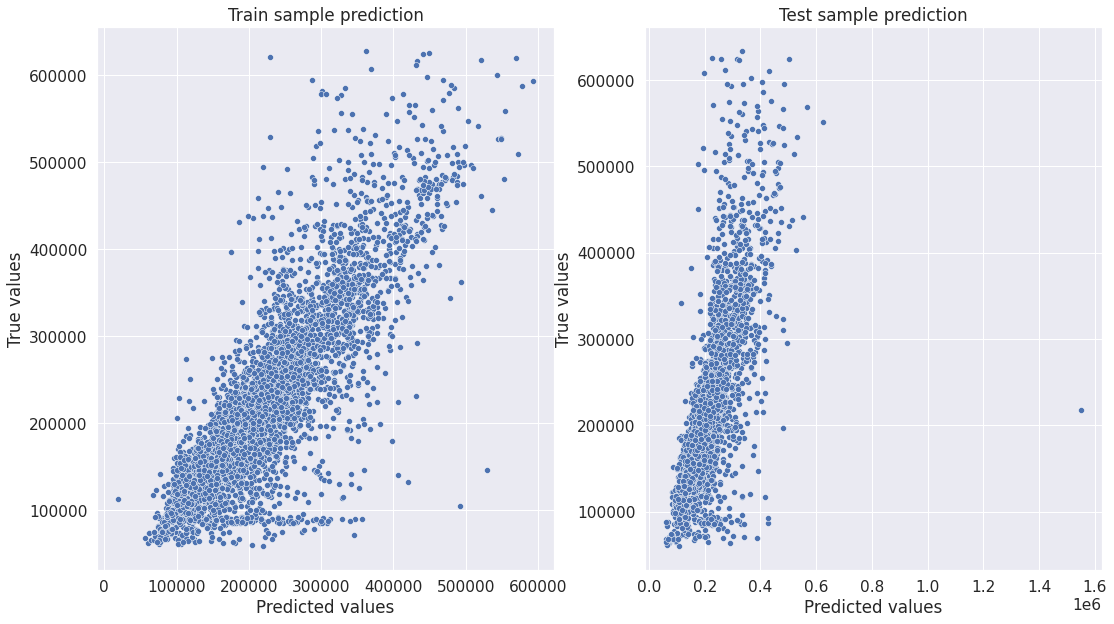

In [ ]:
#from sklearn.linear_model import LinearRegression
#lr_model = LinearRegression()

#lr_model.fit(X_train, y_train)
             
#y_train_preds = lr_model.predict(X_train)
#y_test_preds = lr_model.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

RandomForestRegressor

Train R2:	0.894
Test R2:	0.649


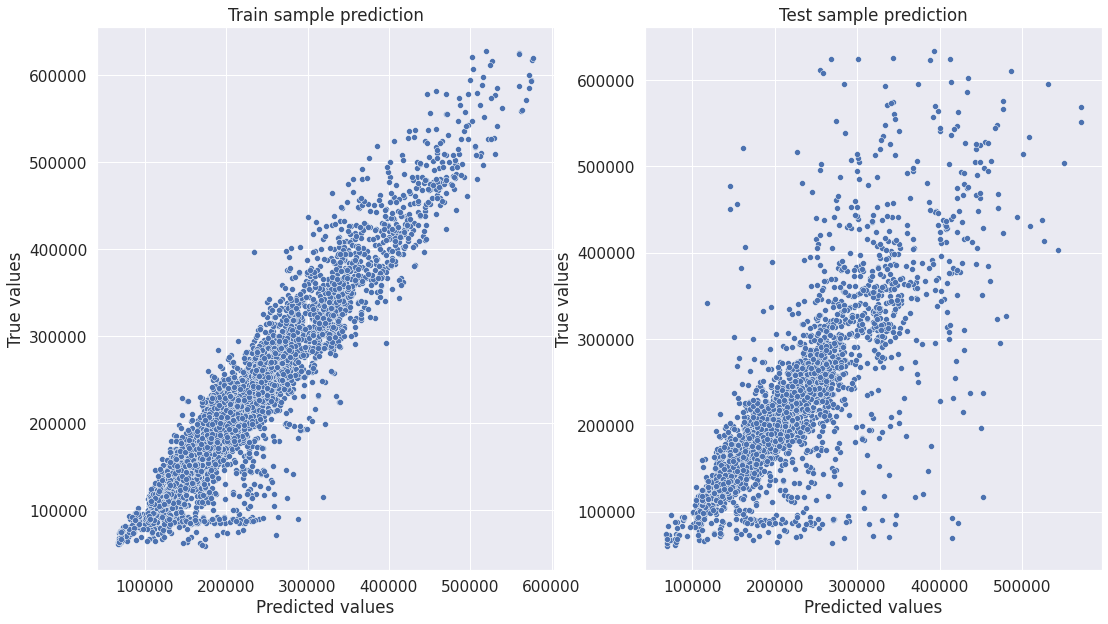

In [ ]:
#%%time
#from sklearn.ensemble import RandomForestRegressor
#rf_model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
#rf_model.fit(X_train, y_train)

#y_train_preds = rf_model.predict(X_train)
#y_test_preds = rf_model.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [ ]:
#from numpy.core.numeric import cross
#from sklearn.model_selection import cross_val_score
#cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
#cv_score

array([0.7260557 , 0.75723672, 0.74660394])

In [ ]:
#cv_score.mean()

0.74329878994993

Важность признаков

In [ ]:
#feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   #columns=['feature_name', 'importance'])

#feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature_name,importance
26,MedPriceByDistrict,0.720071
3,Square,0.088317
4,LifeSquare,0.027880
7,HouseFloor,0.019142
8,HouseYear,0.018614
21,DistrictSize,0.015611
5,KitchenSquare,0.014589
0,Id,0.011191
14,Social_3,0.010917
6,Floor,0.010878


LigthGBMRegressor

Train R2:	0.932
Test R2:	0.68


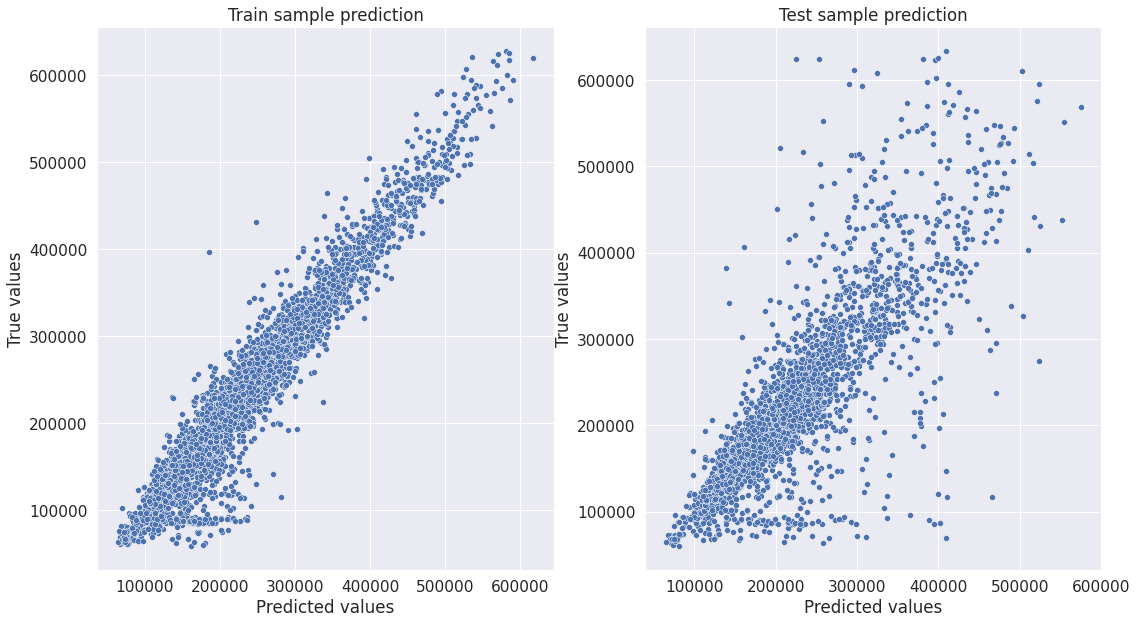

In [ ]:
import lightgbm as lgb

gbm = lgb.LGBMRegressor(max_depth=15, n_estimators=200)
gbm.fit(X_train, y_train)

y_train_preds = gbm.predict(X_train)
y_test_preds = gbm.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(gbm, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.7370534 , 0.76055841, 0.75937628])

In [ ]:
cv_score.mean()

0.7523293651440293

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, gbm.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature_name,importance
3,Square,761
4,LifeSquare,625
26,MedPriceByDistrict,543
0,Id,517
8,HouseYear,504
21,DistrictSize,332
7,HouseFloor,328
9,Ecology_1,325
6,Floor,319
1,DistrictId,278


XGBoost

[13:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train R2:	0.871
Test R2:	0.677


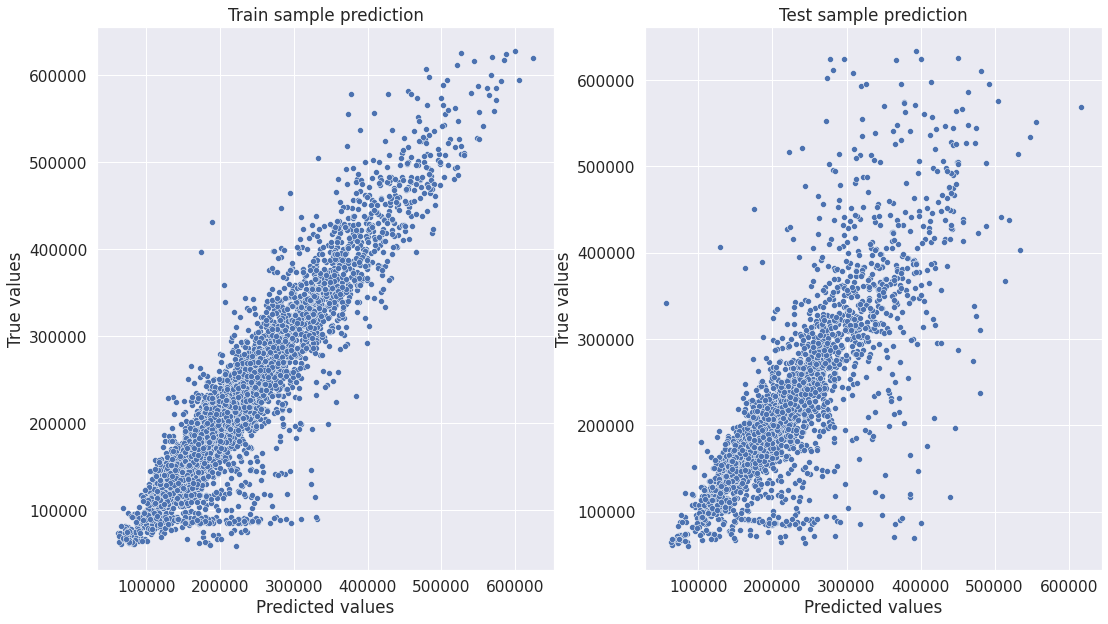

In [ ]:
#from xgboost import XGBRegressor

#xgbr = XGBRegressor(random_state=42,n_estimators=500,max_depth=3)
#xgbr.fit(X_train, y_train)

#y_train_preds = xgbr.predict(X_train)
#y_test_preds = xgbr.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
#cv_score = cross_val_score(xgbr, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
#cv_score

[13:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.72651912, 0.76864671, 0.7682233 ])

In [ ]:
#cv_score.mean()

0.7544630454763399

**7.ПРОГНОЗ по тестовым данным**

**Линейная регрессия**

Train R2: 0.718/
Test R2: 0.523

**RandomForestRegressor**

Train R2:	0.894/
Test R2:	0.649

**LigthGBMRegressor**

Train R2: 0.932/
Test R2: 0.68

**XGBoost**

Train R2: 0.871/
Test R2: 0.677

обучения тестовых получились невысокие, кросс-валидация наибольшая у XGBoost, но практически на LigthGBMRegressor.


Поэтому оставнавлюсь на модели **LigthGBMRegressor**. Остальные оставлю в комментариях

In [ ]:
test_df.shape

(5000, 28)

In [ ]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,0,0,0,70.0,0,0,1.0,1.0,167155.991565,187806.049419
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,0,0,164.0,0,1,2.0,4.0,128808.353899,173192.285142
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,...,0,0,0,568.0,0,1,4.0,1.0,164457.432677,181217.547184
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,0,0,375.0,0,1,0.0,1.0,157606.065847,180398.218571
4,746,74,1.0,53.837056,49.837056,1.0,8,17.0,1977,0.309479,...,0,0,0,76.0,0,0,2.0,1.0,162138.526832,187332.573843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,6.0,1962,0.069660,...,0,1,0,59.0,0,0,2.0,1.0,182289.757727,187332.573843
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,...,0,0,0,25.0,0,0,4.0,4.0,419315.944641,230363.094855
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,...,0,0,0,69.0,0,0,0.0,1.0,148430.871401,180398.218571
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,...,0,0,0,35.0,0,0,2.0,1.0,166024.537530,187332.573843


In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit.head(10)

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0
5,868,200000.0
6,672,200000.0
7,2471,200000.0
8,4510,200000.0
9,8354,200000.0


In [ ]:
predictions = gbm.predict(test_df)
predictions

array([161618.11450527, 128511.19631967, 141391.01811788, ...,
       146635.28126732, 174830.07047542, 286996.61659743])

In [ ]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161618.114505
1,5925,128511.196320
2,960,141391.018118
3,3848,113313.522058
4,746,148216.925800


In [ ]:
submit.to_csv('gbm_submit.csv', index=False)